Since g2 data from measurements are saved in .spe files so we import an external library to read such files to get data in numpy arrays.

In [25]:
# import libraries we need
%pylab inline
import sys
sys.path.append('./py_programs/')
from tensorflow import keras
from sdt_reader import sdtfile
from py_programs import sdt

Populating the interactive namespace from numpy and matplotlib


In [29]:
file = sdtfile.SdtFile('./sdt_data/Antibunching_Rh110_DPC.sdt')

In [36]:
file.block_measure_info

TypeError: block_measure_info() missing 1 required positional argument: 'block'

In [26]:
# read data files
t1, y1 = sdt.read('./sdt_data/Antibunching_Rh110_DPC.sdt')
t2, y2 = sdt.read('./sdt_data/Antibunching_Rh110_Spc.sdt')

In [4]:
# cut off the first and last few zero data points
y2 = y2[np.argwhere(y2>0)].flatten()
t2 = t2[np.argwhere(y2>0)].flatten()

We need to manually set the dip as the zero time delay. And also normalize the g2 signal to its maximum.

In [5]:
# normalize g2 values and zero the time delay
t1_norm, y1_norm = sdt.normalize(t1,y1)
t2_norm, y2_norm = sdt.normalize(t2,y2)

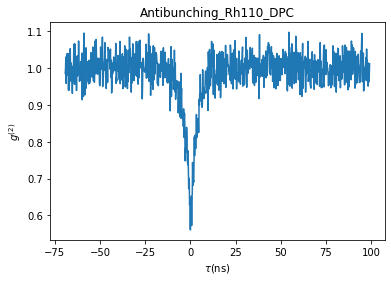

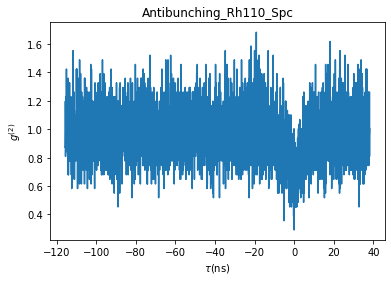

In [6]:
# take a look at the data
plt.figure(1)

plt.title('Antibunching_Rh110_DPC')
plt.xlabel(r'$\tau$(ns)')
plt.ylabel(r'$g^{(2)}$') # un-normalized
plt.plot(t1_norm,y1_norm)

plt.figure(2)

plt.title('Antibunching_Rh110_Spc')
plt.xlabel(r'$\tau$(ns)')
plt.ylabel(r'$g^{(2)}$')
plt.plot(t2_norm,y2_norm)
plt.show()


# MachineLearning Part

To avoid tensorflow occupying all CPUs or GPU in a computer we need to set processing units which tensorflow has access to use.

In [7]:
# this is to limit the GPU and CPUs being occupied by tensorflow
from implementations import tf_setCPU

In [20]:
# create training sequences
#time_step = 2
train = sdt.create_train(y1_norm,time_step)
#train2x, train2y = sdt.create_train(y1,time_step
train1 = train1.reshape(train1.shape[0],train1.shape[1],1)
train2 = sdt.create_train(y2_norm,time_step)
train2 = train2.reshape(train2.shape[0],train2.shape[1],1)

Here I create a [1D CNN](https://keras.io/api/layers/convolution_layers/convolution1d/).

In [21]:
# create a training model
kernelsize = 7
model = keras.Sequential()
model.add(keras.layers.Input(shape=(train1.shape[1],train1.shape[2])))
model.add(keras.layers.Conv1D(filters=32, kernel_size=kernelsize, padding="same", strides=1, activation="relu")) #,input_shape=(train1.shape[0],train1.shape[1],1)
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.Conv1D(filters=16, kernel_size=kernelsize, padding="same", strides=1, activation="relu")) #,input_shape=(train1.shape[0],train1.shape[1],1)
model.add(keras.layers.Conv1DTranspose(filters=16, kernel_size=kernelsize,activation="relu", padding="same"))
model.add(keras.layers.Dropout(rate=0.1))
model.add(keras.layers.Conv1DTranspose(filters=32, kernel_size=kernelsize,activation="relu", padding="same"))
model.add(keras.layers.Conv1DTranspose(filters=1, kernel_size=kernelsize, padding="same"))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 2, 32)             256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 2, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 16)             3600      
_________________________________________________________________
conv1d_transpose_3 (Conv1DTr (None, 2, 16)             1808      
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 16)             0         
_________________________________________________________________
conv1d_transpose_4 (Conv1DTr (None, 2, 32)             3616      
_________________________________________________________________
conv1d_transpose_5 (Conv1DTr (None, 2, 1)             

In [22]:
# training ...
history = model.fit(train2,train2,epochs=20,validation_split=.1)

Epoch 1/20
105/105 [==============================] - 0s 2ms/step - loss: 0.5484 - val_loss: 0.0234
Epoch 2/20
105/105 [==============================] - 0s 746us/step - loss: 0.0258 - val_loss: 0.0166
Epoch 3/20
105/105 [==============================] - 0s 727us/step - loss: 0.0157 - val_loss: 0.0022
Epoch 4/20
105/105 [==============================] - 0s 737us/step - loss: 0.0084 - val_loss: 0.0012
Epoch 5/20
105/105 [==============================] - 0s 730us/step - loss: 0.0073 - val_loss: 9.9977e-04
Epoch 6/20
105/105 [==============================] - 0s 751us/step - loss: 0.0063 - val_loss: 0.0012
Epoch 7/20
105/105 [==============================] - 0s 754us/step - loss: 0.0050 - val_loss: 0.0025
Epoch 8/20
105/105 [==============================] - 0s 756us/step - loss: 0.0044 - val_loss: 0.0016
Epoch 9/20
105/105 [==============================] - 0s 733us/step - loss: 0.0040 - val_loss: 0.0027
Epoch 10/20
105/105 [==============================] - 0s 691us/step - loss: 0.0

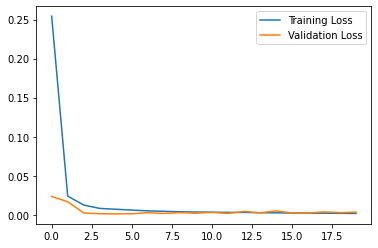

In [23]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [24]:
# use the model to predict data
pred1 = model.predict(train1)
pred2 = model.predict(train2)

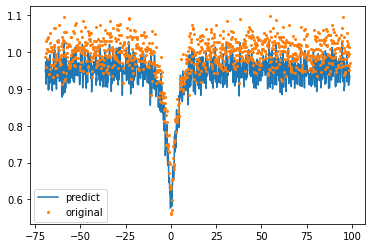

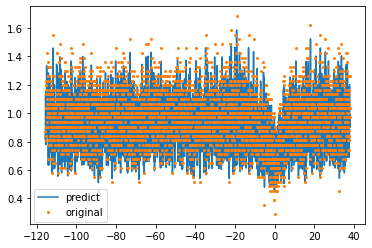

In [26]:
# plot prediction
plt.figure(1)
plt.plot(t1_norm[:-2],pred1[:,1,0],label='predict')
plt.plot(t1_norm[:-2],train1[:,0],'.',markersize=4,label='original')
plt.legend(loc=(0.01,0.01))

plt.figure(2)
plt.plot(t2_norm[:-2],pred2[:,0,0],label='predict')
plt.plot(t2_norm[:-2],train2[:,0],'.',markersize=4,label='original')
plt.legend(loc=(0.01,0.01))
